# Exercises: Exploratory Analysis

<hr style="border:2px solid gray">
<hr style="border:2px solid gray">

In [1]:
import warnings 
warnings.filterwarnings("ignore")

# imports 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import env
from scipy import stats

<div class="alert alert-block alert-danger">
 <div class="row vertical-align">
            <i class="fa fa-exclamation-triangle fa-2x"></i>
<b>Reminder:</b> Be sure that students push .gitignore file prior to adding their env.py
</div>

<div class="alert alert-block alert-info">
<b>Instructor Note:</b> 
    <br>
    <br>
For this exercises review, many instructors choose to have the students demonstrate what they explored as opposed to going through the questions in the curriculum. This can be fun opportunity for the students to learn from eachother and see different types of exploration. You can do this as well, choose to go through the exercises or a combination of both!

# Part I:
Continue in your classification_exercises.ipynb notebook. As always, add, commit, and push your changes.

<b>Section 1</b> - iris_db: Using iris data from our Sequal Ace server and the methods used in the lesson above:

1. Acquire, prepare & split your data.

2. Univariate Stats

    - For each measurement type (quantitative variable): create a histogram, boxplot, & compute descriptive statistics (using .describe()).

    - For each species (categorical variable): create a frequency table and a bar plot of those frequencies.

    - Document takeaways & any actions.

3. Bivariate Stats

    - Visualize each measurement type (y-axis) with the species variable (x-axis) using barplots, adding a horizontal line showing the overall mean of the metric (y-axis).

    - For each measurement type, compute the descriptive statistics for each species.

    - For virginica & versicolor: Compare the mean petal_width using the Mann-Whitney test (scipy.stats.mannwhitneyu) to see if there is a significant difference between the two groups. Do the same for the other measurement types.

    - Document takeaways & any actions.

4. Multivariate Stats

    - Visualize the interaction of each measurement type with the others using a pairplot (or scatter matrix or something similar) and add color to represent species.

    - Visualize two numeric variables of the species. Hint: sns.relplot with hue or col

    - Create a swarmplot using a melted dataframe of all your numeric variables. The x-axis should be the variable name, the y-axis the measure. Add another dimension using color to represent species. Document takeaways from this visualization.

    - Ask a specific question of the data, such as: is the sepal area signficantly different in virginica compared to setosa? Answer the question through both a plot and using a mann-whitney or t-test. If you use a t-test, be sure assumptions are met (independence, normality, equal variance).

    - Document takeaways and any actions.

<hr style="border:2px solid gray">

## #1. Acquire, prepare & split your data.

<b>Planning</b>:
- Can we determine what type of Iris is being examined based on 
- metrics taken from a study of three different species of the flower?
- Do we have significant indicators of what type of species we encounter based on petal or sepal lengths?

<b>Acquire:</b>

<div class="alert alert-block alert-info">
<b>Instructor Note:</b> 
    <br>
    <br>
Students may also chose the following query: 
    <br>
    -- SELECT * FROM measurements JOIN species ON(species.species_id=measurements.species_id)
    <br>
    <br>
    <b>but</b> They will have to drop species_id when they clean
    </div>


In [2]:
# query to acquire the iris data
query = "SELECT measurements.measurement_id, measurements.sepal_length,\
                measurements.sepal_width, measurements.petal_length, \
                measurements.petal_width, species.species_name, species.species_id \
            FROM measurements JOIN species ON(species.species_id=measurements.species_id)"

In [3]:
# function to get the data and run the query
def get_data():
    return pd.read_sql(query, env.get_connection('iris_db'))

In [4]:
# acquire the data
df = get_data()

In [5]:
df.head()

,measurement_id,sepal_length,sepal_width,petal_length,petal_width,species_name,species_id
0,1,5.1,3.5,1.4,0.2,setosa,1
1,2,4.9,3.0,1.4,0.2,setosa,1
2,3,4.7,3.2,1.3,0.2,setosa,1
3,4,4.6,3.1,1.5,0.2,setosa,1
4,5,5.0,3.6,1.4,0.2,setosa,1


<b>Prepare</b>

<div class="alert alert-block alert-info">
<b>Instructor Note:</b> 
    <br>
    <br>
Ask the students what they did to clean up this data.
    <br>
<br>
This dataset is not very messy so we only chose to: 
    <br>
    -- rename columns to make them more readable/less redundent
    <br>
-- remove the columns that are not valuable to us
    </div>

In [6]:
#create a function to rename and remove columns
def clean_iris(df):
    df = df.rename(columns={'species_name': 'species'})
    df = df.drop(columns=['measurement_id', 'species_id'])
    return df

In [7]:
#reassign our clean df 
df = clean_iris(df)

In [8]:
#take a look
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [9]:
#what kind of columns are we dealing with?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


<b>Split</b>

<div class="alert alert-block alert-info">
<b>Instructor Note:</b> 
    <br>
    <br>
We will use sklearn to split our data
    <br>
<br>
We will stratify on our target feature (species)
    <br>
    For classification, our target feature <b>must</b> be categorical.
    <br>
    <br>
    <u>Stratify</u>: This parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify.
    </div>

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# 80/20 train test split
train, test = train_test_split(df, train_size=0.8, random_state=1349, stratify=df.species)

# 70/30 train validate split
train, validate = train_test_split(train, train_size=0.7, random_state=1349, stratify=train.species)

In [12]:
#take a look at each set
train.shape, validate.shape, test.shape

((84, 5), (36, 5), (30, 5))

<hr style="border:1.5px solid black">

## #2. Univariate Stats

<div class="alert alert-block alert-info">
<b>Instructor Note:</b> 
    <br>
    <br>
Univatiate Exploration: to explore features/variables one-by-one.
    </div>

In [13]:
#look at what kind of columns we're dealing with
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 138 to 54
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  84 non-null     float64
 1   sepal_width   84 non-null     float64
 2   petal_length  84 non-null     float64
 3   petal_width   84 non-null     float64
 4   species       84 non-null     object 
dtypes: float64(4), object(1)
memory usage: 3.9+ KB


In [14]:
#look at the data
train.head()

,sepal_length,sepal_width,petal_length,petal_width,species
138,6.0,3.0,4.8,1.8,virginica
7,5.0,3.4,1.5,0.2,setosa
79,5.7,2.6,3.5,1.0,versicolor
74,6.4,2.9,4.3,1.3,versicolor
97,6.2,2.9,4.3,1.3,versicolor


In [15]:
#descriptive stats of numeric columns
train.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal_length,84.0,5.847619,0.841324,4.3,5.075,5.9,6.425,7.7
sepal_width,84.0,3.053571,0.417233,2.0,2.800,3.0,3.300,4.4
petal_length,84.0,3.738095,1.765459,1.0,1.600,4.3,5.100,6.9
petal_width,84.0,1.208333,0.775717,0.1,0.375,1.3,1.800,2.5


### For each measurement type (quantitative variable): create a histogram, boxplot, & compute descriptive statistics (using .describe()).

<div class="alert alert-block alert-info">
<b>Instructor Note:</b> 
    <br>
     <br>
-- quantitative = numeric
     <br>
-- histogram shows us the distribution
     <br>
-- boxplot shows us the outliers
    <br>
    <br>
We can create a "for loop" to do this for each numeric variable we have
<br>
    <br>
    Another choice would be to create numeric columns prior
     <br>
    <i>num_cols= train.select_dtypes(include=['float64'])</i> would also work here

In [16]:
# define num_cols here:
# num_cols could be defined by datatype of float64, or just anything that isn't an object
num_cols = train.columns[[train[col].dtype != 'object' for col in train.columns]]

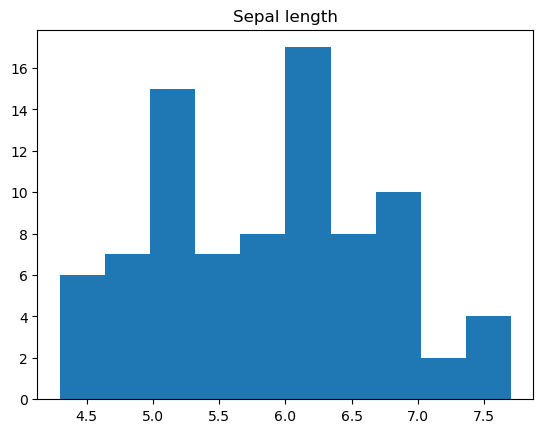

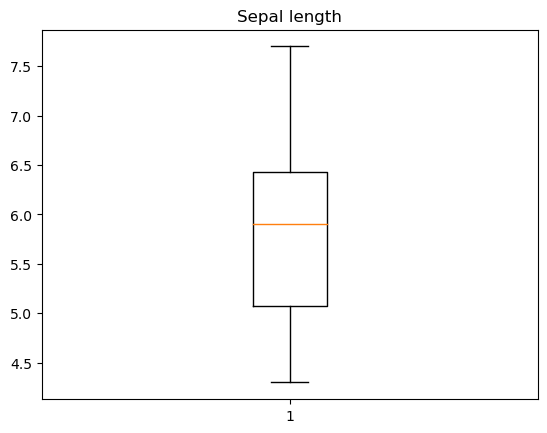

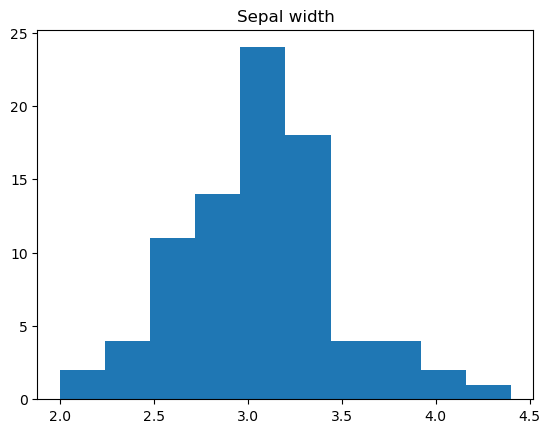

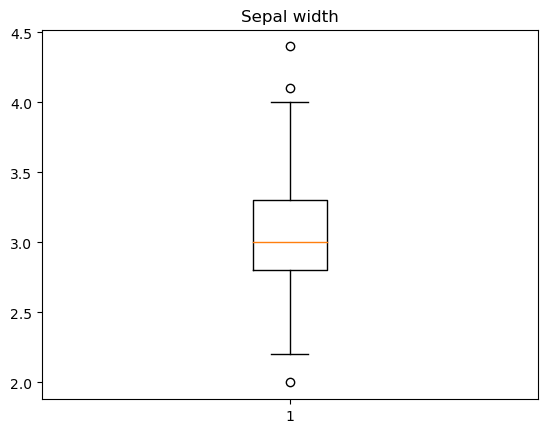

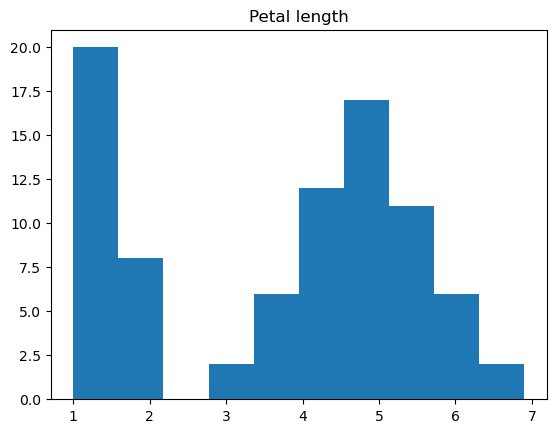

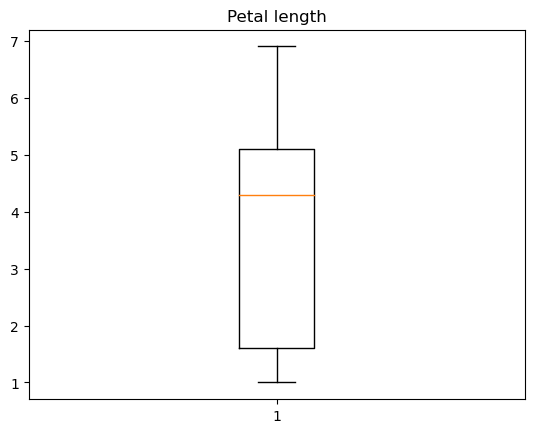

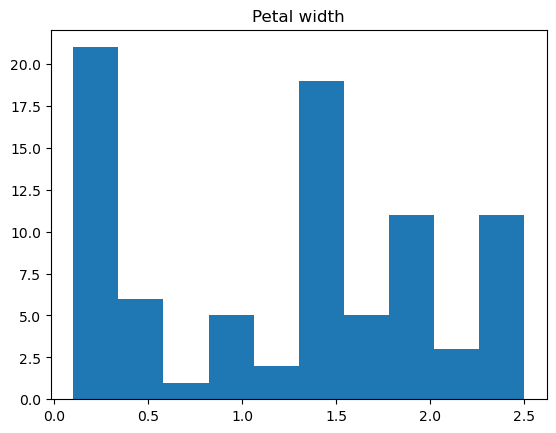

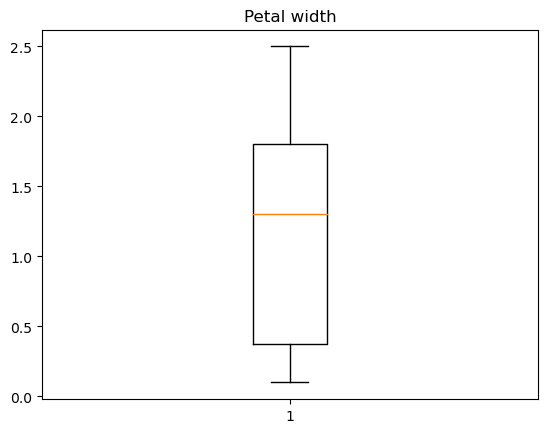

In [17]:
# Plot numeric columns
# every thing in train.columns where the train[col] series is not an object
for col in num_cols:
    #use matplotlib to create a histogram
    #alt formatting: calling train[col].hist()
    plt.hist(train[col])
    # make a title, cleaned up a little with string methods
    plt.title(col.replace('_',' ').capitalize())
    #call plt.show so we have separate visualizations
    plt.show()
    # use matplotlib to create a boxplot
    plt.boxplot(train[col])
    # use the same string methods to clean up the title
    plt.title(col.replace('_',' ').capitalize())
    plt.show()


<div class="alert alert-block alert-success">
    <b>Takeaways:</b>
        <br>
        <br>
-- We observe some significant indication of a bimodal distribution on the feature of Petal length, which seems to point toward the idea that at least one species of Iris has a significantly shorter petal length than the others =====> If we phrased this in continued investigation, we would utilize a means to see if the subset of one species petal length is significantly different/smaller than the other, depending on the tailed-ness of the test we choose to perform.
<br>
-- Additionally, we see potentially interesting spikes in the petal width of the data set, which might point towards associations between groups on our training data in association with our target
<br>
-- Sepal Width looked exceptionally normal for a small(er) data set

<hr style="border:0.25px solid black">

### For each species (categorical variable): create a frequency table and a bar plot of those frequencies.

<div class="alert alert-block alert-info">
    <b>Instructor Note:</b>
    <br>
    <br>
-- categorical/discrete = object
    </div>

In [18]:
train.species.value_counts()

virginica     28
setosa        28
versicolor    28
Name: species, dtype: int64

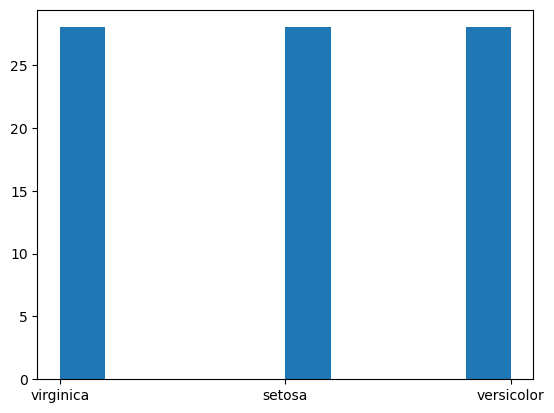

In [19]:
plt.hist(train.species)
plt.show()

<hr style="border:0.25px solid black">

### Document takeaways & any actions.

<div class="alert alert-block alert-success">
    <b>Takeaways:</b>
        <br>
        <br>
        -- We cleaned dataframe by renaming and removing columns
        <br>
        -- It appears that all 3 species have the same amount of samples
        <br>
        -- It does not look like we have a very normal distribution
        <br>
        -- There do not appear to be any outliers in any columns except 'sepal_width'
        </div>

<hr style="border:1.5px solid black">

## #3. Bivariate Stats

<div class="alert alert-block alert-info">
    <b>Instructor Note:</b>
    <br>
    <br>
Bivariate Exploration: the simultaneous analysis of two variables (attributes). It explores the concept of relationship between two variables, whether there exists an association and the strength of this association, or whether there are differences between two variables and the significance of these differences.
    </div>

### Visualize each measurement type (y-axis) with the species variable (x-axis) using barplots, adding a horizontal line showing the overall mean of the metric (y-axis).

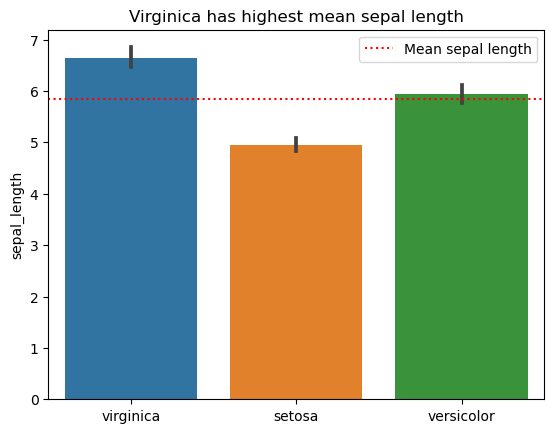

In [20]:
# we retroactively place our takeaway from this visualization as the title
plt.title("Virginica has highest mean sepal length")
# calling seaborn for a bar plot, specifying species and sepal length
sns.barplot(x="species", y="sepal_length", data=train)
# annotate a mean of the sepal length
# calculating a mean of the sepal length (for *all* the species)
mean_sepal_length = train.sepal_length.mean()
# place the calculated mean as a horizontal axis line
plt.axhline(mean_sepal_length, label="Mean sepal length", color='red', linestyle='dotted')
plt.xlabel('')
plt.legend()
plt.show()

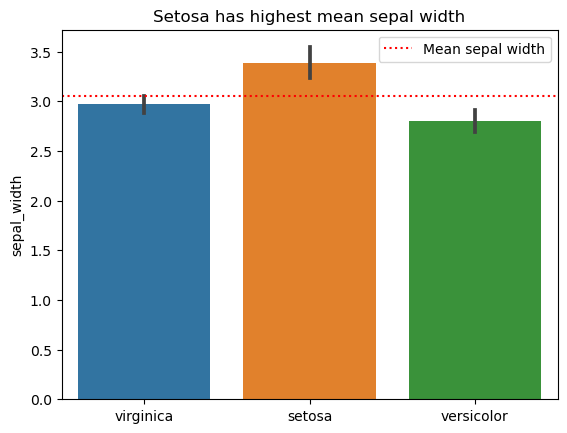

In [21]:
# change sepal length to sepal width, run same process
plt.title("Setosa has highest mean sepal width")
sns.barplot(x="species", y="sepal_width", data=train)
mean_sepal_width = train.sepal_width.mean()
plt.axhline(mean_sepal_width, label="Mean sepal width", color='red', linestyle='dotted')
plt.xlabel('')
plt.legend()
plt.show()

- It looks like Setosas have a shorter/fatter sepal compared to the other two species, it may provide extra value toward our target if we combine these features into area(?) Will investigate further

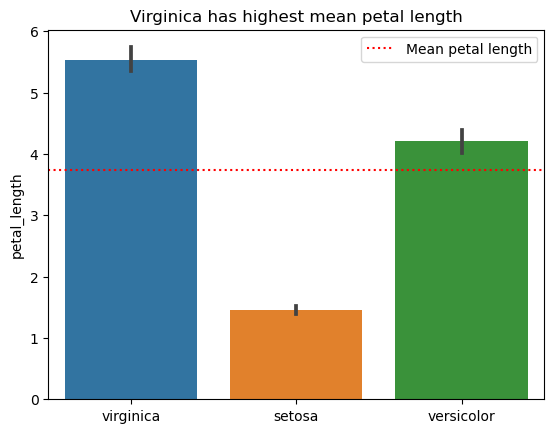

In [22]:
plt.title("Virginica has highest mean petal length")
sns.barplot(x="species", y="petal_length", data=train)
mean_petal_length = train.petal_length.mean()
plt.axhline(mean_petal_length, label="Mean petal length", color='red', linestyle='dotted')
plt.xlabel('')
plt.legend()
plt.show()

- Setosa has a significantly smaller petal length than either of the other two species

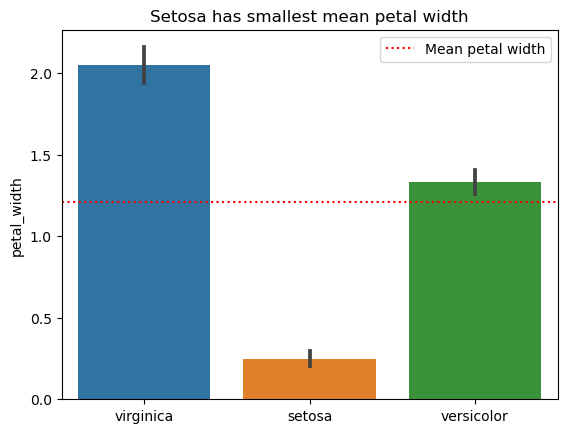

In [23]:
plt.title("Setosa has smallest mean petal width")
sns.barplot(x="species", y="petal_width", data=train)
mean_petal_width = train.petal_width.mean()
plt.axhline(mean_petal_width, label="Mean petal width", color='red', linestyle='dotted')
plt.xlabel('')
plt.legend()
plt.show()

<hr style="border:0.25px solid black">

### For each measurement type, compute the descriptive statistics for each species.

In [24]:
# Virginica descriptive statistics
# train, where train.species is virginica
virginica_describe = train[train.species == 'virginica'].describe().T

In [25]:
virginica_describe

,count,mean,std,min,25%,50%,75%,max
sepal_length,28.0,6.650000,0.532986,5.8,6.3,6.60,6.900,7.7
sepal_width,28.0,2.975000,0.260519,2.2,2.8,3.00,3.200,3.4
petal_length,28.0,5.539286,0.525173,4.8,5.1,5.55,5.825,6.9
petal_width,28.0,2.046429,0.294998,1.5,1.8,2.05,2.300,2.5


In [26]:
# Setosa descriptive statistics
setosa_describe = train[train.species == 'setosa'].describe().T

In [27]:
setosa_describe

,count,mean,std,min,25%,50%,75%,max
sepal_length,28.0,4.957143,0.362531,4.3,4.775,5.00,5.100,5.8
sepal_width,28.0,3.385714,0.433516,2.3,3.100,3.35,3.625,4.4
petal_length,28.0,1.457143,0.185450,1.0,1.400,1.50,1.600,1.9
petal_width,28.0,0.246429,0.129048,0.1,0.200,0.20,0.325,0.6


In [28]:
# Versicolor descriptive statistics
versicolor_describe = train[train.species == 'versicolor'].describe().T

In [29]:
versicolor_describe

,count,mean,std,min,25%,50%,75%,max
sepal_length,28.0,5.935714,0.512231,5.0,5.600,6.0,6.3,6.9
sepal_width,28.0,2.800000,0.303071,2.0,2.700,2.9,3.0,3.4
petal_length,28.0,4.217857,0.522142,3.0,3.900,4.3,4.6,5.1
petal_width,28.0,1.332143,0.205577,1.0,1.275,1.3,1.5,1.7


<hr style="border:0.25px solid black">

### For virginica & versicolor: Compare the mean petal_width using the Mann-Whitney test (scipy.stats.mannwhitneyu) to see if there is a significant difference between the two groups. Do the same for the other measurement types.

<div class="alert alert-block alert-info">
    <b>Instructor Note:</b>
    <br>
    <br>
    <u>Ask students</u>: Why would we want to do a Mann-Whitney test here?
    <br>
    <u>Answer</u>: T-Test compares 2 variables (categorical & continuuous) <b>BUT</b> a Mann-Whitney is a non-parametric test, so we use this instead because our data is <b>not</b> normally distributed.

In [30]:
virginica = train[train.species == 'virginica']
versicolor = train[train.species == 'versicolor']
setosa = train[train.species == 'setosa']

t, p = stats.mannwhitneyu(virginica.petal_width, versicolor.petal_width, alternative="two-sided")
t, p

(768.5, 5.964779617392898e-10)

<div class="alert alert-block alert-success">
    <b>Takeaways:</b>
        <br>
        <br>
We have a significantly lower p value than 0.05, we can reject the null hypotehsis
</div>

In [31]:
test_var = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
for var in test_var:
    t, p = t, p = stats.mannwhitneyu(virginica[var], versicolor[var], alternative="two-sided")
    print(f'Comparing {var} between virginica and versicolor')
    print(t, p)
    print('------------------')
    print('\n')

Comparing sepal_length between virginica and versicolor
652.0 2.0239840631681243e-05
------------------


Comparing sepal_width between virginica and versicolor
534.0 0.019016025589853748
------------------


Comparing petal_length between virginica and versicolor
771.5 5.050690113298581e-10
------------------


Comparing petal_width between virginica and versicolor
768.5 5.964779617392898e-10
------------------




<hr style="border:0.25px solid black">

### Document takeaways & any actions.

<div class="alert alert-block alert-success">
    <b>Takeaways:</b>
    <br>
petal_length and petal_width show the most seperation between species.
    <br>
    
Could petal and sepal area be useful features?
     <br>
    
- viginica iris have the largest petals.
     <br>
- setosa iris have the smallest petals.
     <br>
- setosa seem to have wide & short sepals.
    </div>

<hr style="border:1.5px solid black">

## #4. Multivariate Stats

<div class="alert alert-block alert-info">
    <b>Instructor Note:</b>
    <br>
    <br>
    Multivariate Exploration: more than two variables have to be analyzed simultaneously

### Visualize the interaction of each measurement type with the others using a pairplot (or scatter matrix or something similar) and add color to represent species.

In [32]:
#create new column that is area
train['sepal_area'] = train['sepal_length'] * train['sepal_width']
train['petal_area'] = train['petal_length'] * train['petal_width']

In [33]:
#let's look at our new dataframe
train.head()

,sepal_length,sepal_width,petal_length,petal_width,species,sepal_area,petal_area
138,6.0,3.0,4.8,1.8,virginica,18.00,8.64
7,5.0,3.4,1.5,0.2,setosa,17.00,0.30
79,5.7,2.6,3.5,1.0,versicolor,14.82,3.50
74,6.4,2.9,4.3,1.3,versicolor,18.56,5.59
97,6.2,2.9,4.3,1.3,versicolor,17.98,5.59


<div class="alert alert-block alert-info">
    <b>Instructor Note:</b>
    <br>
    <br>
    We can accomplish this by using itertools to give us the combinations <b>or</b> we can create our own combinations by using a pairplot to visualize them then calling the indexes
    </div>

In [34]:
import itertools

In [35]:
list(itertools.combinations(train.drop(columns='species').columns, 2))

[('sepal_length', 'sepal_width'),
 ('sepal_length', 'petal_length'),
 ('sepal_length', 'petal_width'),
 ('sepal_length', 'sepal_area'),
 ('sepal_length', 'petal_area'),
 ('sepal_width', 'petal_length'),
 ('sepal_width', 'petal_width'),
 ('sepal_width', 'sepal_area'),
 ('sepal_width', 'petal_area'),
 ('petal_length', 'petal_width'),
 ('petal_length', 'sepal_area'),
 ('petal_length', 'petal_area'),
 ('petal_width', 'sepal_area'),
 ('petal_width', 'petal_area'),
 ('sepal_area', 'petal_area')]

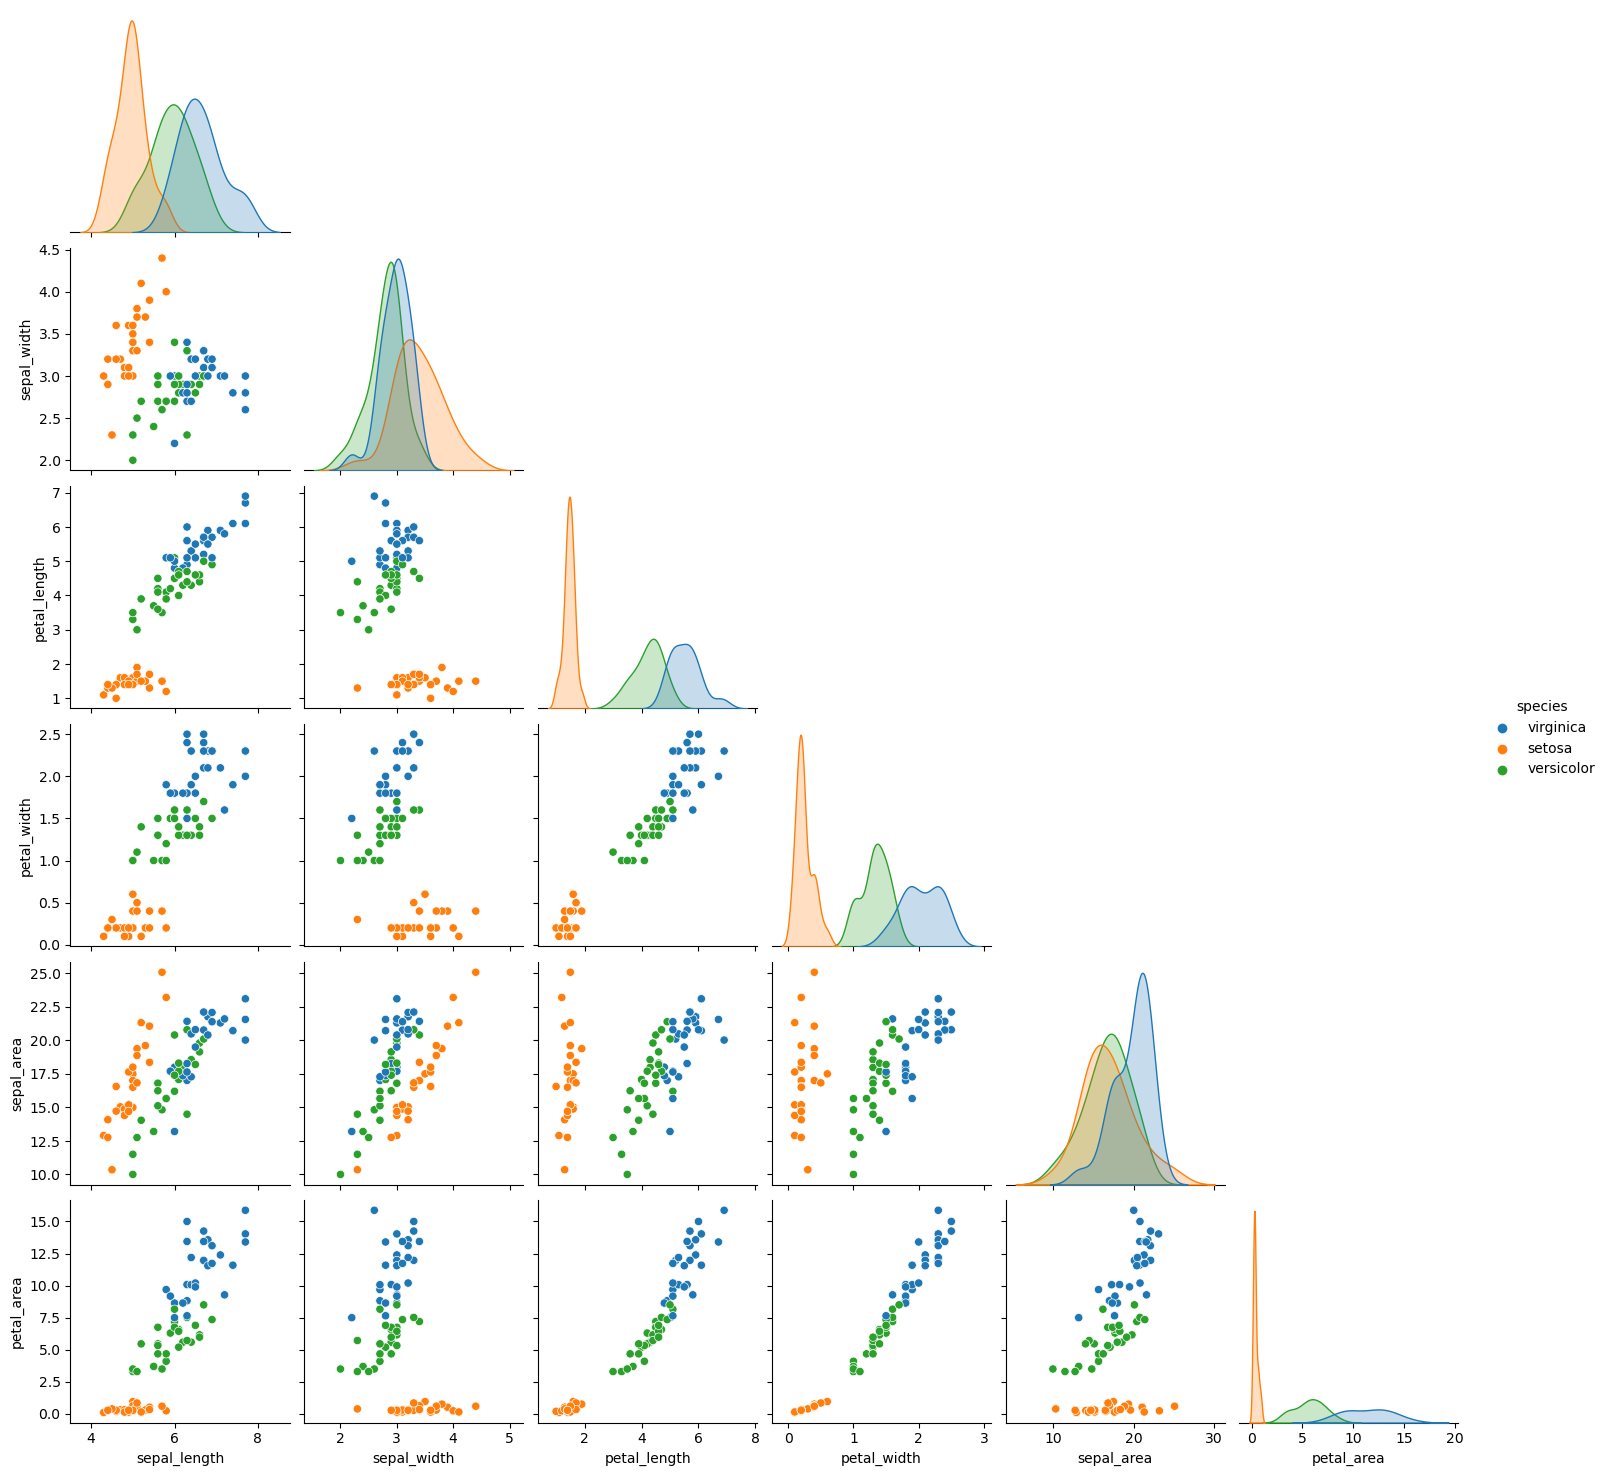

In [36]:
sns.pairplot(train, hue='species', corner=True)
plt.show()

In [37]:
#assign a variable to our combinations
# define feature combinations with a list of tuples
combos = [
    ('sepal_length', 'sepal_width'),
    ('petal_length', 'petal_width'),
    ('sepal_area', 'petal_area'),
    ('sepal_length', 'petal_length')
]

In [38]:
#call the index that you want to see, in our case length and width of sepal
combos[0]

('sepal_length', 'sepal_width')

In [39]:
# we can use aggretations to examine specific stats on our categorical target
train.groupby('species')['sepal_area'].sum()

species
setosa        473.12
versicolor    467.81
virginica     554.13
Name: sepal_area, dtype: float64

In [40]:
#assign x to sepal length
x = combos[0][0]
#assign y to sepal width
y = combos[0][1]

In [41]:
#create a function to create scatterplots that group by species
def scatter_species(x, y):
    for species, subset in train.groupby('species'):
        plt.scatter(subset[x], subset[y], label=species)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.legend()

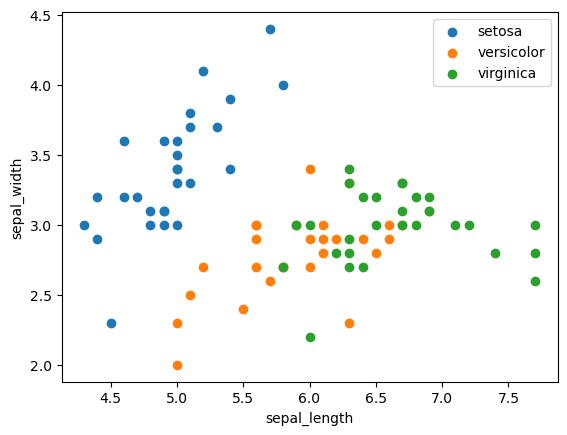

In [42]:
# test it with one plot
scatter_species(x,y)

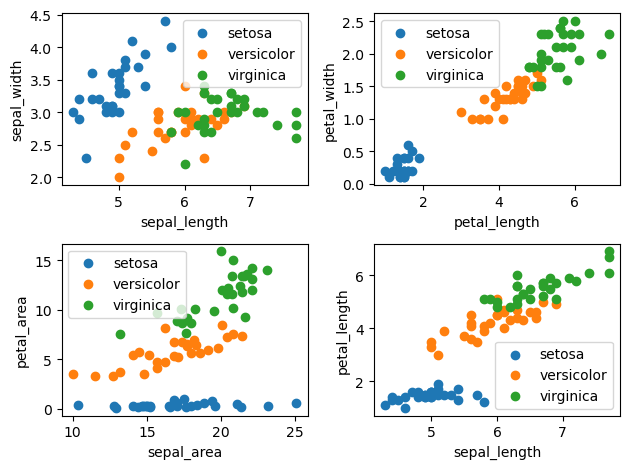

In [43]:
#Now, let's use our new function with subplots
plt.subplot(2,2,1)
scatter_species(combos[0][0], combos[0][1])
plt.subplot(2,2,2)
scatter_species(combos[1][0], combos[1][1])
plt.subplot(2,2,3)
scatter_species(combos[2][0], combos[2][1])
plt.subplot(2,2,4)
scatter_species(combos[3][0], combos[3][1])
plt.tight_layout()

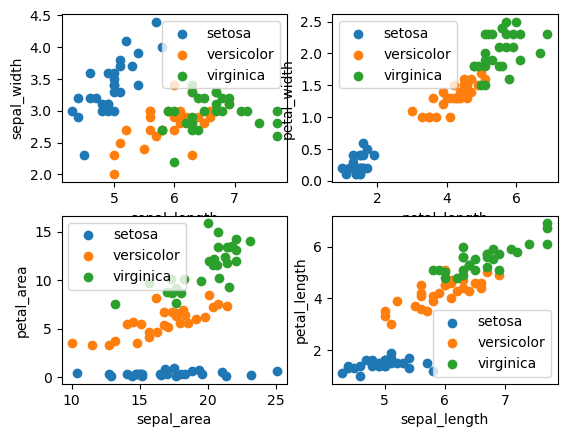

In [44]:
for i, pair in enumerate(combos):
    plt.subplot(2,2,i+1)
    scatter_species(pair[0], pair[1])

<div class="alert alert-block alert-success">
    <b>Takeaways:</b>
<br>
    
-- sepal_length is useful, sepal_width not great but likely adds some value.
    <br>
-- petal_area is very useful, as we would expect given the previous plot of petal_width x petal length.
    <br>
-- sepal_area is questionable, as we don't see much separation when we look at the 3rd plot in a hortizonal direction. Again, some value in sepal width, but not a ton.
    <br>
-- A heatmap of each variable layering correlation coefficient on top.

<div class="alert alert-block alert-info">
<b>Instructor Note:</b> 
    <br>
    <br>
    Tell students: Do <i>not</i> put a heatmap with all correlation coefficients labeled as is in a presentation! A heatmap can be useful with minimal detail included. Maybe adding extreme values labeled. But not like this! This is for <b>YOUR</b> exploration.   
    </div>

<hr style="border:0.25px solid black">

### Visualize two numeric variables of the species. Hint: sns.relplot with hue or col

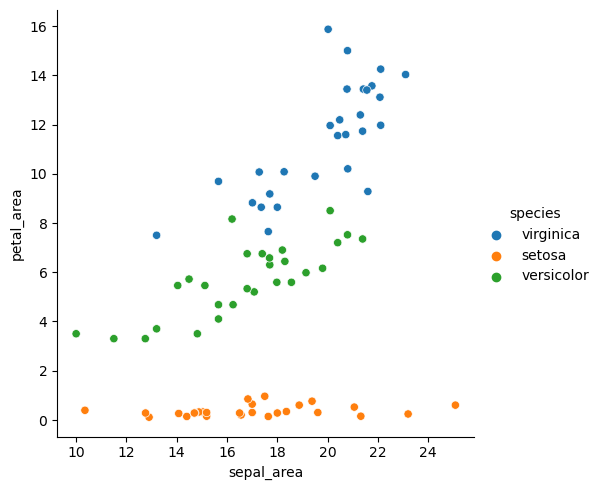

In [45]:
#using hue to divide by species
sns.relplot(data=train, x='sepal_area', y='petal_area', kind='scatter', hue='species')

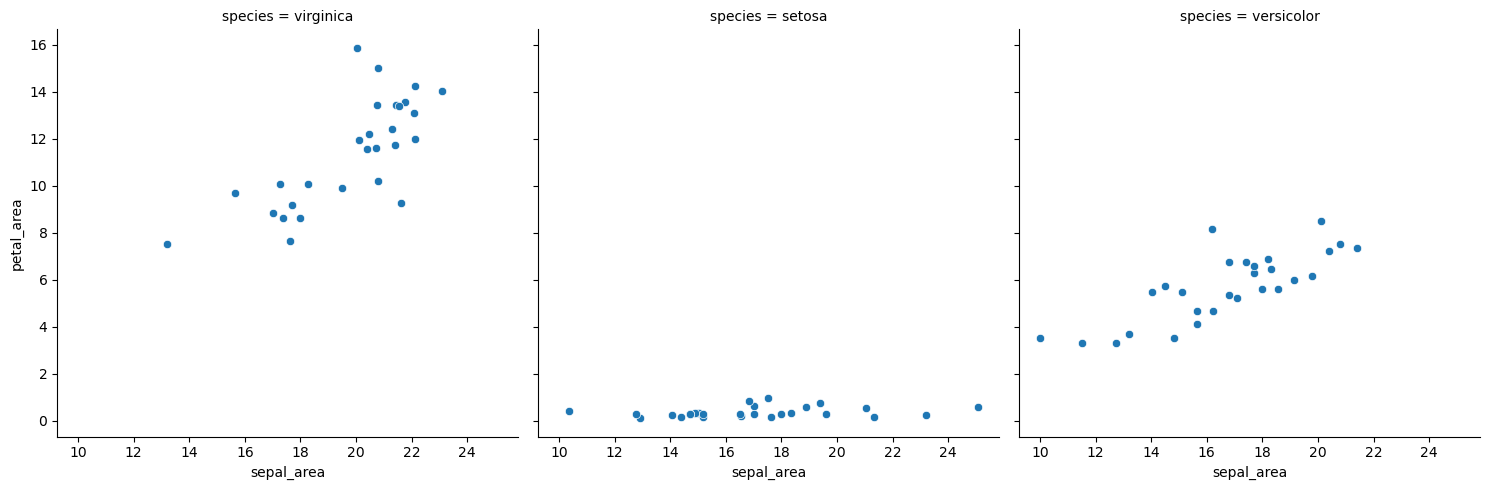

In [46]:
#using col to divide into seperate graphs by species
sns.relplot(data=train, x='sepal_area', y='petal_area', kind='scatter',col='species')

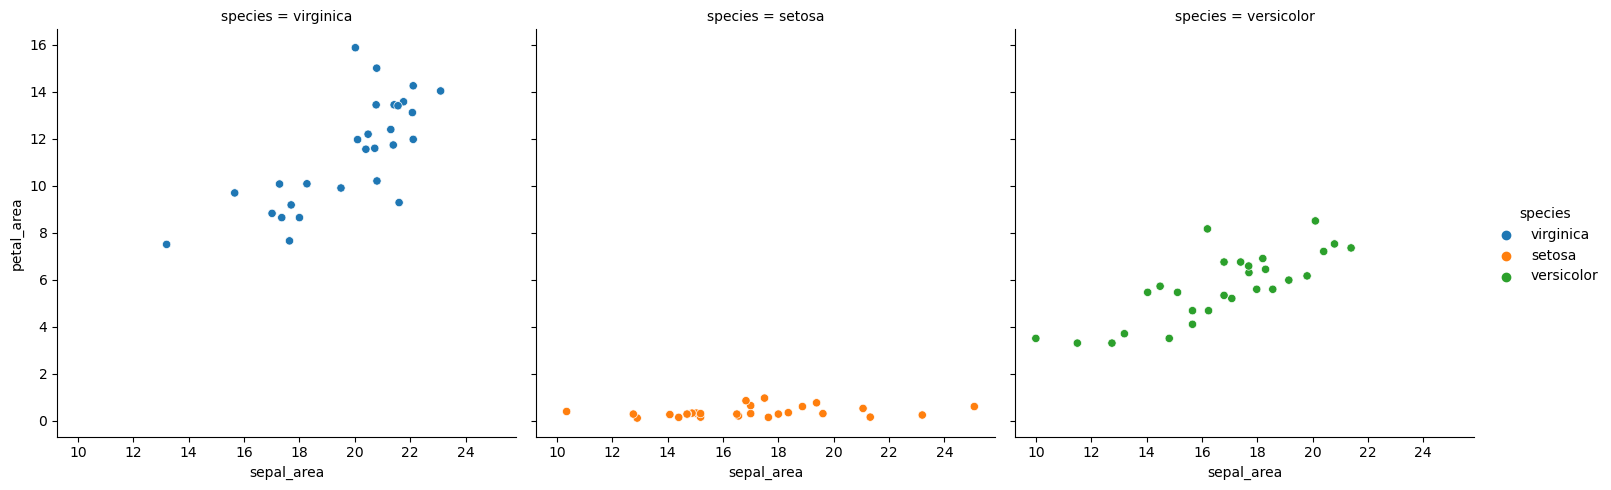

In [47]:
#combine hue and col
sns.relplot(data=train, x='sepal_area', y='petal_area', kind='scatter', hue='species', col='species')

<hr style="border:0.25px solid black">

### Create a swarmplot using a melted dataframe of all your numeric variables. The x-axis should be the variable name, the y-axis the measure. Add another dimension using color to represent species. Document takeaways from this visualization.

<div class="alert alert-block alert-info">
<b>Instructor Note:</b> 
    <br>
    <br>
    x-axis: all features  
        <br>
        y-axis: measurement/value (size of that feature)
            <br>
            color: use hue to add dimension by species
    </div>

<AxesSubplot:xlabel='species', ylabel='sepal_length'>

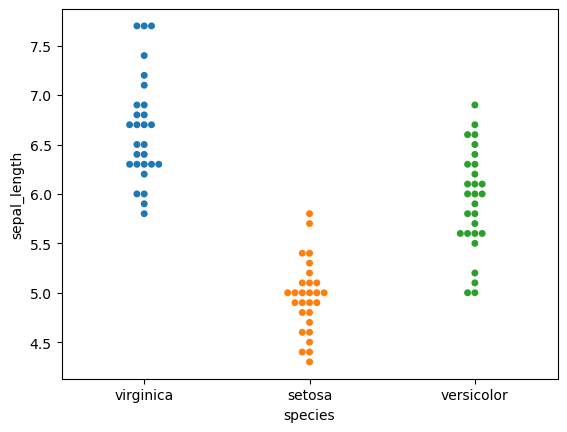

In [48]:
#let's look a swarmplot by species and sepal length
sns.swarmplot(data=train, x='species', y='sepal_length')

In [49]:
#remember what our dataframe looks like
train.head()

,sepal_length,sepal_width,petal_length,petal_width,species,sepal_area,petal_area
138,6.0,3.0,4.8,1.8,virginica,18.00,8.64
7,5.0,3.4,1.5,0.2,setosa,17.00,0.30
79,5.7,2.6,3.5,1.0,versicolor,14.82,3.50
74,6.4,2.9,4.3,1.3,versicolor,18.56,5.59
97,6.2,2.9,4.3,1.3,versicolor,17.98,5.59


In [50]:
#create a new df 
train_melt = train.melt(id_vars = 'species')

<div class="alert alert-block alert-info">
<b>Instructor Note:</b> 
    <br>
    <br>
<b>.melt</b>: This function is useful to massage a DataFrame into a format where one or more columns are identifier variables (id_vars), while all other columns, considered measured variables (value_vars), are “unpivoted” to the row axis, leaving just two non-identifier columns, ‘variable’ and ‘value’.
    <br>
     <br>
-- Has argument <i>id_vars</i> which takes in column(s) to use as identifier variables.
<br>
--- In this case, we are using species, which is our target variable
    </div>

In [51]:
train_melt.head()

,species,variable,value
0,virginica,sepal_length,6.0
1,setosa,sepal_length,5.0
2,versicolor,sepal_length,5.7
3,versicolor,sepal_length,6.4
4,versicolor,sepal_length,6.2


<AxesSubplot:xlabel='variable', ylabel='value'>

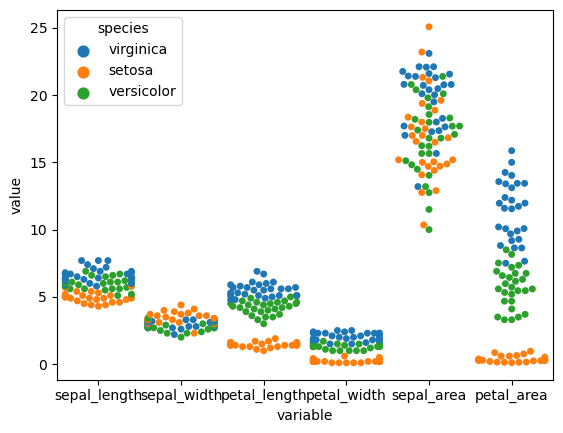

In [52]:
#let's create our swarmplot from our melted dataframe
sns.swarmplot(data=train_melt, x='variable', y='value', hue='species')

<hr style="border:0.25px solid black">

### Ask a specific question of the data, such as: is the sepal area signficantly different in virginica compared to setosa? Answer the question through both a plot and using a mann-whitney or t-test. If you use a t-test, be sure assumptions are met (independence, normality, equal variance).

<div class="alert alert-block alert-info">
<b>Instructor Note:</b> 
    <br>
    <br>
<b>.corr()</b>: used to find the pairwise correlation of all columns 
    <br>
    You can specify a method of finding that correlation (or not):
        <br>
        -- pearson: standard correlation coefficient 
            <br>
-- kendall: Kendall Tau correlation coefficient 
    <br>
-- spearman: Spearman rank correlation
    <br>
     <br>
<b>.heatmap()</b>: a two-dimensional graphical representation of data where the individual values that are contained in a matrix are represented as colors
    <br>
    -- Paired with <i>.corr()</i> this will give you a visualization of correlations
    </div>

In [53]:
#We can check to see if there is correlation between variables
train.corr()

,sepal_length,sepal_width,petal_length,petal_width,sepal_area,petal_area
sepal_length,1.000000,-0.166612,0.900357,0.860775,0.685879,0.885277
sepal_width,-0.166612,1.000000,-0.415310,-0.323396,0.599240,-0.272634
petal_length,0.900357,-0.415310,1.000000,0.965383,0.429428,0.958520
petal_width,0.860775,-0.323396,0.965383,1.000000,0.473277,0.980366
sepal_area,0.685879,0.599240,0.429428,0.473277,1.000000,0.526012
petal_area,0.885277,-0.272634,0.958520,0.980366,0.526012,1.000000


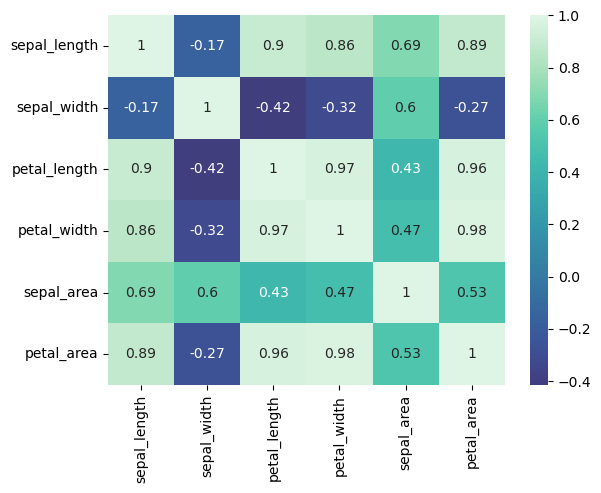

In [54]:
sns.heatmap(train.corr(), cmap='mako', center=0, annot=True)
plt.show()

<div class="alert alert-block alert-success">
<b>Takeaways:</b>
<br>
    <br>
-- Most measures correlate with each other, the least is sepal_width with sepal_lenght @ -.15.
<br>
-- Negative correlations: Wider sepals => shorter & narrower petals (smaller petal areas)
<br>
-- Positive correlations: Longer sepals => longer & wider petals (larger petal areas)
<br>
-- Little to no <b>LINEAR</b> correlation: sepal length & sepal width.
    </div>

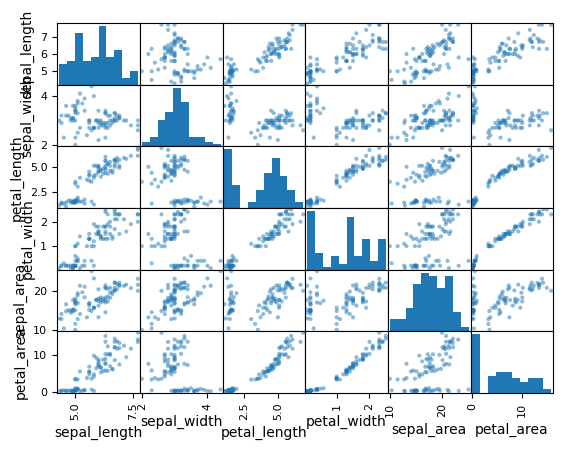

In [55]:
pd.plotting.scatter_matrix(train)
plt.show()

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 138 to 54
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  84 non-null     float64
 1   sepal_width   84 non-null     float64
 2   petal_length  84 non-null     float64
 3   petal_width   84 non-null     float64
 4   species       84 non-null     object 
 5   sepal_area    84 non-null     float64
 6   petal_area    84 non-null     float64
dtypes: float64(6), object(1)
memory usage: 7.3+ KB


<div class="alert alert-block alert-success">
<b>Takeaways:</b>
<br>
    <br>
-- petal length + petal width show the most seperation between species.
     <br>
-- setosa has the shortest and narrowest petals. It will be the easiest to determine.
     <br>
-- petal area seems to show the largest separation between virginica & versicolor of all the individual features.
     <br>
-- virginica shows slightly longer sepals, but whether that difference is significant, it's hard to say.
     <br>
-- virginica and versicolor show little to no difference when it comes to the width of the sepals.
    </div>

<b>Hypothesis</b>

alpha = .05

$H_0$: Sepal length is the same in virginica and versicolor. $μ_{virginica}$ == $μ_{versicolor}$ .

$H_a$: Sepal length significantly different in virginica and versicolor. $μ_{virginica}$ != $μ_{versicolor}$.

In [57]:
virginica = train[train['species'] == 'virginica']
versicolor = train[train['species'] == 'versicolor']

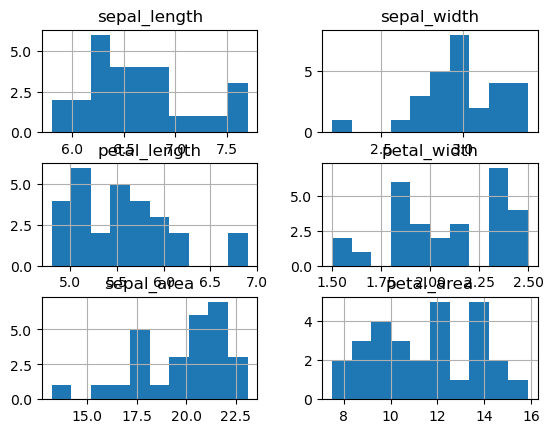

In [58]:
virginica.hist()
plt.show()

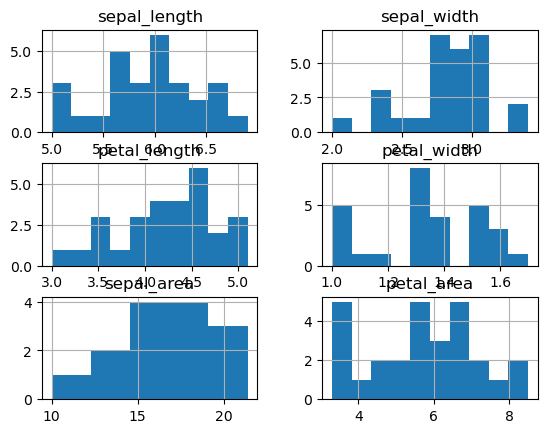

In [59]:
versicolor.hist()
plt.show()

In [60]:
versicolor.describe()['sepal_length']

count    28.000000
mean      5.935714
std       0.512231
min       5.000000
25%       5.600000
50%       6.000000
75%       6.300000
max       6.900000
Name: sepal_length, dtype: float64

In [61]:
import scipy.stats as stats

In [62]:
tstat, p = stats.ttest_ind(virginica.sepal_length,
                versicolor.sepal_length, 
                equal_var=False
               )

tstat, p

(5.11297615624047, 4.3042670668773595e-06)

<hr style="border:0.25px solid black">

### Document takeaways and any actions

<b>Conclusion</b>

We reject  that the sepal length is the same for both groups.

<b>Takeaway</b>

Sepal length will be a useful feature.
What about sepal_width? Let's use the Mann-Whitney test for demo purposes.

<b>Hypothesis</b>

alpha = .05
for randomly selected values X and Y from two populations, the probability of X being greater than Y is equal to the probability of Y being greater than X.

$H_0$: For randomly selected values of sepal width, the probability of sepal width for virginica being greater than the sepal width for versicolor is equal to the probability of sepal width for versicolor being greater than the sepal width for virginica.

  p(virginica > versicolor) == p(versicolor > virginica)

$H_a$: The probability of randomly selected values being larger than each other by class is not equal. $μ_{virginica}$ != $μ_{versicolor}$.

<hr style="border:2px solid black">
<hr style="border:2px solid black">

# Part II:
Explore your titanic dataset more completely.

    - Determine drivers of the target variable
    - Determine if certain columns should be dropped
    - Determine if it would be valuable to bin some numeric columns
    - Determine if it would be valuable to combine multiple columns into one.
<br>

- Does it make sense to combine any features?

- Do you find any surprises?

- Document any and all findings and takeaways in your notebook using markdown.

<b>Acquire</b>: 

<div class="alert alert-block alert-info">
<b>Instructor Note:</b> 
    <br>
    <br>
We will use a previous function that we made in the acquire lesson. It brings in the titanic_df from Sequel Ace and writes it to a csv if there is not already one.
    </div>

In [63]:
#custom import from the acquire lesson
import acquire

In [64]:
#assign titanic_df to the function we created
titanic_df = acquire.get_titanic_data()

In [65]:
#take a look at the data
titanic_df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [66]:
#what kind of columns are we dealing with?
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passenger_id  891 non-null    int64  
 1   survived      891 non-null    int64  
 2   pclass        891 non-null    int64  
 3   sex           891 non-null    object 
 4   age           714 non-null    float64
 5   sibsp         891 non-null    int64  
 6   parch         891 non-null    int64  
 7   fare          891 non-null    float64
 8   embarked      889 non-null    object 
 9   class         891 non-null    object 
 10  deck          203 non-null    object 
 11  embark_town   889 non-null    object 
 12  alone         891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 97.5+ KB


<div class="alert alert-block alert-success">
<b>Takeaways:</b>
<br>
    <br>
-- Deck column should be dropped because it is 77% null 
     <br>
-- embark_town has a small number of nulls, so we can fill that with most common value
     <br>
-- pclass and class seem to be duplicate columns, we can drop class because it is an object
     <br>
-- passenger_id is the same as index, so we can drop that
     <br>
-- embarked and embarked_town are the same, so we can drop one.
     <br>
-- age column has 20% nulls, we can fill this with most frequent age
</div>

<b>Prepare</b>: 

<div class="alert alert-block alert-info">
<b>Instructor Note:</b> 
    <br>
    <br>
We have a function from the prepare lesson 'clean_titanic_data' that will do the cleaning for us, but for this lesson, let's walk through with the students.
    </div>

In [67]:
def clean_titanic_data(df):
    '''
    This function will clean the data prior to splitting.
    '''
    # Drops any duplicate values
    df = df.drop_duplicates()

    # Drops columns that are already represented by other columns
    cols_to_drop = ['deck', 'embarked', 'class', 'passenger_id']
    df = df.drop(columns=cols_to_drop)

    # Fills the small number of null values for embark_town with the mode
    df['embark_town'] = df.embark_town.fillna(value='Southampton')

    # Uses one-hot encoding to create dummies of string columns for future modeling 
    dummy_df = pd.get_dummies(df[['sex', 'embark_town']], dummy_na=False, drop_first=[True])
    df = pd.concat([df, dummy_df], axis=1)

    return df

In [68]:
#assign this to clean_df so it doesn't give us an error later
clean_df= clean_titanic_data(titanic_df)

In [69]:
#take a look at our 'clean' data
clean_df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embark_town,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
0,0,3,male,22.0,1,0,7.2500,Southampton,0,1,0,1
1,1,1,female,38.0,1,0,71.2833,Cherbourg,0,0,0,0
2,1,3,female,26.0,0,0,7.9250,Southampton,1,0,0,1
3,1,1,female,35.0,1,0,53.1000,Southampton,0,0,0,1
4,0,3,male,35.0,0,0,8.0500,Southampton,1,1,0,1


<div class="alert alert-block alert-success">
<b>Takeaways:</b>
<br>
    <br>
-- We were able to create a function that does the cleaning for us.
    <br>
-- We can now focus on splitting the data and creating new functions
</div>

<b>Split</b>:

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [71]:
def split_titanic_data(df):
    '''
    Takes in a dataframe and return train, validate, test subset dataframes
    '''
    # Creates the test set
    train, test = train_test_split(df, test_size = .2, random_state=123, stratify=df.survived)
    
    # Creates the final train and validate set
    train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train.survived)
    
    return train, validate, test

In [72]:
def impute_titanic_mode(train, validate, test):
    '''
    Takes in train, validate, and test, and uses train to identify the best value to replace nulls in embark_town
    Imputes that value into all three sets and returns all three sets
    '''
    imputer = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
    train[['embark_town']] = imputer.fit_transform(train[['embark_town']])
    validate[['embark_town']] = imputer.transform(validate[['embark_town']])
    test[['embark_town']] = imputer.transform(test[['embark_town']])
    return train, validate, test

In [73]:
def impute_mean_age(train, validate, test):
    '''
    This function imputes the mean of the age column for
    observations with missing values.
    Returns transformed train, validate, and test df.
    '''
    # create the imputer object with mean strategy
    imputer = SimpleImputer(strategy = 'mean')
    
    # fit on and transform age column in train
    train['age'] = imputer.fit_transform(train[['age']])
    
    # transform age column in validate
    validate['age'] = imputer.transform(validate[['age']])
    
    # transform age column in test
    test['age'] = imputer.transform(test[['age']])
    
    return train, validate, test

In [74]:
def prep_titanic_data(df):
    '''
    Combines the clean_titanic_data, split_titanic_data, and impute_mean_age functions.
    '''
    df = clean_titanic_data(df)

    train, validate, test = split_titanic_data(df)
    
    train, validate, test = impute_mean_age(train, validate, test)

    return train, validate, test

In [75]:
train, validate, test = prep_titanic_data(titanic_df)

In [76]:
train.head()

,survived,pclass,sex,age,sibsp,parch,fare,embark_town,alone,sex_male,embark_town_Queenstown,embark_town_Southampton
583,0,1,male,36.000000,0,0,40.1250,Cherbourg,1,1,0,0
165,1,3,male,9.000000,0,2,20.5250,Southampton,0,1,0,1
50,0,3,male,7.000000,4,1,39.6875,Southampton,0,1,0,1
259,1,2,female,50.000000,0,1,26.0000,Southampton,0,0,0,1
306,1,1,female,29.678105,0,0,110.8833,Cherbourg,1,0,0,0


In [77]:
train.shape, validate.shape, test.shape

((498, 12), (214, 12), (179, 12))

<div class="alert alert-block alert-success">
<b>Takeaways:</b>
<br>
    <br>
-- We created multiple functions to impute age with mean, impute embarked_town with most frequent
     <br>
-- We combined all the smaller functions into one "mother function" called prep_titanic_data
     <br>
</div>

<hr style="border:1.5px solid black">
<hr style="border:1.5px solid black">

# Part III:
Explore your telco data to discover drivers of churn

    - Determine if certain columns should be dropped
    - Determine if it would be valuable to bin some numeric columns
    - Determine if it would be valuable to combine multiple columns into one. 
   
   <br>   
- What are your drivers of churn?

- Does it make sense to combine any features?

- Do you find any surprises?

- Document any and all findings and takeaways in your notebook using markdown.

<b>Acquire:</b>

<div class="alert alert-block alert-info">
<b>Instructor Note:</b> 
    <br>
    <br>
We will use a previous function that we made in the acquire lesson. It brings in the telco_df from Sequel Ace and writes it to a csv if there is not already one.
    </div>

In [78]:
import acquire

In [79]:
telco_df = acquire.get_telco_data()

In [80]:
telco_df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


In [81]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [82]:
telco_df.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


<div class="alert alert-block alert-success">
<b>Takeaways:</b>
<br>
    <br>
-- It looks like there are several columns that will need to be converted from binary categorical variables to numeric
     <br>
-- We will have to change total_charges from object to a float
     <br>
-- There are several duplicate columns that we can drop
     <br>
-- We will need to create dummy columns
</div>

<b>Prepare:</b>

<div class="alert alert-block alert-info">
<b>Instructor Note:</b> 
    <br>
    <br>
We have a function from the prepare lesson 'prep_telco_dta' that will do the cleaning for us, but for this lesson, let's walk through with the students.
    </div>

In [83]:
# Drop duplicate columns
telco_df.drop(columns=['payment_type_id', 'internet_service_type_id', 'contract_type_id', 'customer_id'], inplace=True)

In [84]:
#Take a look and make. sure columns are dropped
telco_df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,Male,0,No,No,9,Yes,Yes,No,No,No,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,Male,0,No,No,4,Yes,No,No,No,Yes,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,Female,1,Yes,No,3,Yes,No,No,No,No,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


In [85]:
# Drop null values stored as whitespace    
telco_df['total_charges'] = telco_df['total_charges'].str.strip()
telco_df = telco_df[telco_df.total_charges != '']
    
# Convert to correct datatype
telco_df['total_charges'] = telco_df.total_charges.astype(float)

In [86]:
#make sure our datatypes were changed correctly
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gender                 7032 non-null   object 
 1   senior_citizen         7032 non-null   int64  
 2   partner                7032 non-null   object 
 3   dependents             7032 non-null   object 
 4   tenure                 7032 non-null   int64  
 5   phone_service          7032 non-null   object 
 6   multiple_lines         7032 non-null   object 
 7   online_security        7032 non-null   object 
 8   online_backup          7032 non-null   object 
 9   device_protection      7032 non-null   object 
 10  tech_support           7032 non-null   object 
 11  streaming_tv           7032 non-null   object 
 12  streaming_movies       7032 non-null   object 
 13  paperless_billing      7032 non-null   object 
 14  monthly_charges        7032 non-null   float64
 15  tota

In [87]:
# Convert binary categorical variables to numeric
telco_df['gender_encoded'] = telco_df.gender.map({'Female': 1, 'Male': 0})
telco_df['partner_encoded'] = telco_df.partner.map({'Yes': 1, 'No': 0})
telco_df['dependents_encoded'] = telco_df.dependents.map({'Yes': 1, 'No': 0})
telco_df['phone_service_encoded'] = telco_df.phone_service.map({'Yes': 1, 'No': 0})
telco_df['paperless_billing_encoded'] = telco_df.paperless_billing.map({'Yes': 1, 'No': 0})
telco_df['churn_encoded'] = telco_df.churn.map({'Yes': 1, 'No': 0})

In [88]:
# Get dummies for non-binary categorical variables
dummy_df = pd.get_dummies(telco_df[['multiple_lines', \
                              'online_security', \
                              'online_backup', \
                              'device_protection', \
                              'tech_support', \
                              'streaming_tv', \
                              'streaming_movies', \
                              'contract_type', \
                              'internet_service_type', \
                              'payment_type']], dummy_na=False, \
                              drop_first=True)

In [89]:
# Concatenate dummy dataframe to original 
telco_df = pd.concat([telco_df, dummy_df], axis=1)

In [90]:
#take a look at our new prepared and cleaned df
telco_df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,...,1,0,0,1,0,0,0,0,0,1
1,Male,0,No,No,9,Yes,Yes,No,No,No,...,0,0,1,0,0,0,0,0,0,1
2,Male,0,No,No,4,Yes,No,No,No,Yes,...,0,0,0,0,0,1,0,0,1,0
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,...,1,0,1,0,0,1,0,0,1,0
4,Female,1,Yes,No,3,Yes,No,No,No,No,...,1,0,0,0,0,1,0,0,0,1


In [91]:
#do we have the columns and dtypes we want?
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 47 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7032 non-null   object 
 1   senior_citizen                         7032 non-null   int64  
 2   partner                                7032 non-null   object 
 3   dependents                             7032 non-null   object 
 4   tenure                                 7032 non-null   int64  
 5   phone_service                          7032 non-null   object 
 6   multiple_lines                         7032 non-null   object 
 7   online_security                        7032 non-null   object 
 8   online_backup                          7032 non-null   object 
 9   device_protection                      7032 non-null   object 
 10  tech_support                           7032 non-null   object 
 11  stre

<div class="alert alert-block alert-success">
<b>Takeaways:</b>
<br>
    <br>
-- We've created many dummy column so we can explore
     <br>
-- We can save all of these changes into a function
     <br>
</div>

<b>Split:</b>

<div class="alert alert-block alert-info">
<b>Instructor Note:</b> 
    <br>
    <br>
We will stratify on churn because that will be our target variable
</div>

In [92]:
# 80/20 train test split
train, test = train_test_split(telco_df, train_size=0.8, random_state=1349, stratify=telco_df.churn)

# 70/30 train validate split
train, validate = train_test_split(train, train_size=0.7, random_state=1349, stratify=train.churn)

In [93]:
train.shape, validate.shape, test.shape

((3937, 47), (1688, 47), (1407, 47))

In [94]:
#create a function for later use
def split_telco_data(df):
    '''
    This function performs split on telco data, stratify churn.
    Returns train, validate, and test dfs.
    '''
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df.churn)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.churn)
    return train, validate, test

<div class="alert alert-block alert-info">
<b>Instructor Note:</b> 
    <br>
<br>
We can put all of our steps together. Now, next time we look into telco data, it will be clean and prepared for us. We can go straight to exploring!
</div>

In [95]:
#put all our above steps together into a function!

def prep_telco_data(df):
    # Drop duplicate columns
    df.drop(columns=['payment_type_id', 'internet_service_type_id', 'contract_type_id', 'customer_id'], inplace=True)
       
    # Drop null values stored as whitespace    
    df['total_charges'] = df['total_charges'].str.strip()
    df = df[df.total_charges != '']
    
    # Convert to correct datatype
    df['total_charges'] = df.total_charges.astype(float)
    
    # Convert binary categorical variables to numeric
    df['gender_encoded'] = df.gender.map({'Female': 1, 'Male': 0})
    df['partner_encoded'] = df.partner.map({'Yes': 1, 'No': 0})
    df['dependents_encoded'] = df.dependents.map({'Yes': 1, 'No': 0})
    df['phone_service_encoded'] = df.phone_service.map({'Yes': 1, 'No': 0})
    df['paperless_billing_encoded'] = df.paperless_billing.map({'Yes': 1, 'No': 0})
    df['churn_encoded'] = df.churn.map({'Yes': 1, 'No': 0})
    
    # Get dummies for non-binary categorical variables
    dummy_df = pd.get_dummies(df[['multiple_lines', \
                              'online_security', \
                              'online_backup', \
                              'device_protection', \
                              'tech_support', \
                              'streaming_tv', \
                              'streaming_movies', \
                              'contract_type', \
                              'internet_service_type', \
                              'payment_type']], dummy_na=False, \
                              drop_first=True)
    
    # Concatenate dummy dataframe to original 
    df = pd.concat([df, dummy_df], axis=1)
    
    # split the data
    train, validate, test = split_telco_data(df)
    
    return train, validate, test

<div class="alert alert-block alert-success">
<b>Takeaways:</b>
<br>
    <br>
-- Creating mother functions with all of our little functions cuts down on our work next time
     <br>
-- We can now just jump into our exploration
     <br>
</div>